# Problem Statement

#### In this project, the objective is to design and implement a system that recognizes five predefined hand gestures to control a smart television. These gestures will enable users to interact with the TV without requiring a remote control. 

#### The gestures are captured as video sequences through a webcam, and each gesture corresponds to a specific command:
* Thumbs Up: Increase the volume.
* Thumbs Down: Decrease the volume.
* Left Swipe: Jump backward 10 seconds.
* Right Swipe: Jump forward 10 seconds.
* Stop: Pause the video.

#### The system should classify video sequences into one of these five gestures with high accuracy and generalize well across unseen data.

#### Each video consists of 30 frames, recorded at 2-3 seconds in length. The frames vary in resolution—either 360x360 or 120x160, depending on the recording device. Preprocessing is essential to standardize these inputs for training and evaluation.

# Project Goals

### The ultimate goal is to:
* Develop a robust gesture recognition model for the Smart TV.
* Ensure real-time processing capabilities with minimal latency.
* Use an optimized architecture with a balance between performance and efficiency.
* Demonstrate the process through experimentation, iterating over multiple model architectures to achieve optimal results.

# COMMON STEPS

### These are the common steps that are being used for all experiments. Step 0 to step 5. The main experiments start from Step 6 onwards.

# Step 0: Unzipping Data

In [102]:
import zipfile

# Unzipping and loading the dataset
dataset_zip_path = "Project_data.zip"  # Path to the dataset zip file
extract_path = './'  # Directory where the zip file will be extracted

# Unzip the dataset
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:  # Open the zip file in read mode
    zip_ref.extractall(extract_path)  # Extract all contents into the specified directory

print("Dataset unzipped successfully.")  # Print success message

Dataset unzipped successfully.


# Step 1 : Import Libraries

In [103]:
import os  # For file and path operations
import numpy as np  # For numerical operations and handling arrays
import pandas as pd # Easy to read data from CSV files into a DataFrame object.
import cv2  # For image processing
from tensorflow.keras.utils import to_categorical  # For converting labels to one-hot encoded format
from tensorflow.keras.models import Model, Sequential  # For building deep learning models
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense, 
                                     TimeDistributed, GRU, Conv3D, MaxPooling3D, Dropout)  # Neural network layers
from tensorflow.keras.optimizers import Adam  # Optimizer for training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Tools for monitoring training

# Step 2 : Reading Data

### The paths for training and validation data, as well as their corresponding CSV files, are defined here. These paths are essential for locating the dataset and enabling subsequent operations like loading and preprocessing.

In [104]:
# Set the base path for your project
base_path = "/Users/stillkraftphotography/Gesture Recognition Project/Project_data"

# Set the data paths
train_path = os.path.join(base_path, "train")  # Path to the training data directory
val_path = os.path.join(base_path, "val")  # Path to the validation data directory
train_csv = os.path.join(base_path, "train.csv")  # Path to the training CSV file
val_csv = os.path.join(base_path, "val.csv")  # Path to the validation CSV file

# Debugging: Check paths
print(f"Train Directory: {train_path}")
print(f"Val Directory: {val_path}")
print(f"Train CSV: {train_csv}")
print(f"Val CSV: {val_csv}")

# Verify existence of directories and files
assert os.path.exists(base_path), f"Base path does not exist: {base_path}"
assert os.path.exists(train_path), f"Training directory not found at {train_path}"
assert os.path.exists(val_path), f"Validation directory not found at {val_path}"
assert os.path.exists(train_csv), f"Training CSV not found at {train_csv}"
assert os.path.exists(val_csv), f"Validation CSV not found at {val_csv}"

print("All paths verified successfully!")

Train Directory: /Users/stillkraftphotography/Gesture Recognition Project/Project_data/train
Val Directory: /Users/stillkraftphotography/Gesture Recognition Project/Project_data/val
Train CSV: /Users/stillkraftphotography/Gesture Recognition Project/Project_data/train.csv
Val CSV: /Users/stillkraftphotography/Gesture Recognition Project/Project_data/val.csv
All paths verified successfully!


# Step 3: Data Understanding

In [105]:
# Read the CSV files into DataFrame objects
train_data = pd.read_csv(train_csv)  # Read the training CSV file into a DataFrame
val_data = pd.read_csv(val_csv)  # Read the validation CSV file into a DataFrame

# Display the first few rows of the DataFrame objects
train_data.head(), val_data.head()

(  WIN_20180925_17_08_43_Pro_Left_Swipe_new;Left_Swipe_new;0
 0  WIN_20180925_17_18_28_Pro_Left_Swipe_new;Left_...       
 1  WIN_20180925_17_18_56_Pro_Left_Swipe_new;Left_...       
 2  WIN_20180925_17_19_51_Pro_Left_Swipe_new;Left_...       
 3  WIN_20180925_17_20_14_Pro_Left_Swipe_new;Left_...       
 4  WIN_20180925_17_21_28_Pro_Left_Swipe_new;Left_...       ,
   WIN_20180925_17_17_04_Pro_Left_Swipe_new;Left_Swipe_new;0
 0  WIN_20180925_17_43_01_Pro_Left_Swipe_new;Left_...       
 1  WIN_20180925_18_01_40_Pro_Left_Swipe_new;Left_...       
 2  WIN_20180925_18_03_21_Pro_Left_Swipe_new;Left_...       
 3  WIN_20180926_16_46_22_Pro_Left_Swipe_new;Left_...       
 4  WIN_20180926_16_47_09_Pro_Left_Swipe_new;Left_...       )

# Step 4: Fix the Data Issue identified

### The uploaded CSV files appear to have data in a non-standard format, where multiple values are concatenated into a single column separated by semicolons (;). To address this issue, we need to split the columns and ensure the data structure is correct.

In [106]:
# Fix the structure of the CSV files by splitting on semicolon (;)
train_data_fixed = train_data.iloc[:, 0].str.split(';', expand=True)
val_data_fixed = val_data.iloc[:, 0].str.split(';', expand=True)

# Assign column names based on the expected structure
train_data_fixed.columns = ['folder_name', 'gesture_name', 'label']
val_data_fixed.columns = ['folder_name', 'gesture_name', 'label']

# Convert the label column to numeric for both train and validation data
train_data_fixed['label'] = pd.to_numeric(train_data_fixed['label'], errors='coerce')
val_data_fixed['label'] = pd.to_numeric(val_data_fixed['label'], errors='coerce')

# Check the first few rows of the processed files
train_data_fixed.head(), val_data_fixed.head()

(                                folder_name    gesture_name  label
 0  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new      0
 1  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new      0
 2  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new      0
 3  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new      0
 4  WIN_20180925_17_21_28_Pro_Left_Swipe_new  Left_Swipe_new      0,
                                 folder_name    gesture_name  label
 0  WIN_20180925_17_43_01_Pro_Left_Swipe_new  Left_Swipe_new      0
 1  WIN_20180925_18_01_40_Pro_Left_Swipe_new  Left_Swipe_new      0
 2  WIN_20180925_18_03_21_Pro_Left_Swipe_new  Left_Swipe_new      0
 3  WIN_20180926_16_46_22_Pro_Left_Swipe_new  Left_Swipe_new      0
 4  WIN_20180926_16_47_09_Pro_Left_Swipe_new  Left_Swipe_new      0)

# Step 5: Save the Cleaned Data

In [107]:
# Set the base path for your project
base_path = "/Users/stillkraftphotography/Gesture Recognition Project/Project_data"

# Save the cleaned training and validation CSV files
cleaned_train_csv_path = os.path.join(base_path, 'cleaned_train.csv')
cleaned_val_csv_path = os.path.join(base_path, 'cleaned_val.csv')

# Save the fixed dataframes to new CSV files
train_data_fixed.to_csv(cleaned_train_csv_path, index=False)
val_data_fixed.to_csv(cleaned_val_csv_path, index=False)

# Confirm file saving
cleaned_train_csv_path, cleaned_val_csv_path

('/Users/stillkraftphotography/Gesture Recognition Project/Project_data/cleaned_train.csv',
 '/Users/stillkraftphotography/Gesture Recognition Project/Project_data/cleaned_val.csv')

# EXPERIMENT NO.1

#### The original experiment focus was to explore and compare two architectures for gesture recognition in video sequences:
* Conv2D + GRU Model
* Conv3D Model

#### Key Focus Areas for the Original Experiment:
* Preprocessing: Standardizing video dimensions and normalizing pixel values for consistency.
Baseline Architectures:
* Experimenting with default parameters like filter sizes, GRU units, and dropout for the Conv2D + GRU model.
* Using standard 3D Conv filters for the Conv3D model.
* Evaluation: Measure the performance (accuracy, loss) of both models on validation data to determine a baseline for future optimization.

# Step 6: Define Global Parameters

### These global parameters standardize the input dimensions and define key aspects of the model training process, such as batch size, number of frames per video, and the number of classes.


In [7]:
# Global Parameters
IMG_HEIGHT, IMG_WIDTH = 120, 120  # Dimensions to resize all frames to
NUM_FRAMES = 30  # Number of frames in each video
BATCH_SIZE = 16  # Number of samples per batch during training
NUM_CLASSES = 5  # Number of output gesture classes

# Step 7: Load and Pre-Process data

### This utility function loads video frames from a given path, resizes them to the standardized dimensions, normalizes the pixel values, and returns them as a NumPy array. This ensures all videos have uniform input characteristics for model training.

In [17]:
# Utility: Load video frames and preprocess them
def load_video_frames(video_path):
    frames = []  # List to store the frames
    # Get a sorted list of all files in the directory
    frame_files = sorted([os.path.join(video_path, f) for f in os.listdir(video_path) if f.endswith('.jpg')])
    
    if len(frame_files) < NUM_FRAMES:
        raise ValueError(f"Insufficient frames in {video_path}. Found {len(frame_files)}, expected {NUM_FRAMES}.")

    for frame_file in frame_files[:NUM_FRAMES]:  # Take only the required number of frames
        img = cv2.imread(frame_file)  # Read the frame
        if img is not None:
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))  # Resize the image
            img = img / 255.0  # Normalize pixel values
            frames.append(img)  # Append to the frame list
        else:
            raise ValueError(f"Error reading file: {frame_file}")
    
    return np.array(frames)  # Return as a NumPy array


# Step 8: Create Data Generator

### The generator function loads batches of video data on-the-fly during training. This approach minimizes memory usage by processing only the current batch in memory. It also shuffles the dataset for better generalization during training.


In [26]:
# Generator function
def load_video_frames(video_path):
    frames = []
    # Include multiple image extensions
    frame_files = sorted([os.path.join(video_path, f) for f in os.listdir(video_path) if f.endswith(('.jpg', '.png'))])
    
    if len(frame_files) < NUM_FRAMES:
        raise ValueError(f"Insufficient frames in {video_path}. Found {len(frame_files)}, expected {NUM_FRAMES}.")

    for frame_file in frame_files[:NUM_FRAMES]:
        img = cv2.imread(frame_file)
        if img is not None:
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            img = img / 255.0
            frames.append(img)
        else:
            raise ValueError(f"Error reading file: {frame_file}")
    
    return np.array(frames)

# Step 9: Build Conv2D + GRU Model

### This model combines 2D convolutional layers for spatial feature extraction with a GRU layer for temporal sequence modeling. The model uses TimeDistributed layers to process video frames independently before passing the features to the GRU layer.


In [27]:
# Build Conv2D + GRU Model
def build_conv2d_gru_model():
    video_input = Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))  # Input shape for videos
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(video_input)  # Apply 2D Conv to each frame
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)  # Apply max pooling to reduce dimensions
    x = TimeDistributed(Flatten())(x)  # Flatten spatial features
    x = GRU(64, return_sequences=False)(x)  # GRU processes the sequence of features
    output = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer with softmax for classification
    model = Model(inputs=video_input, outputs=output)  # Define the model
    model.compile(optimizer=Adam(learning_rate=0.001),  # Compile with Adam optimizer
                  loss='categorical_crossentropy', metrics=['accuracy'])  # Use cross-entropy loss for classification
    return model

# Step 10: Build Conv3D Model

### The Conv3D model processes video data as a 3D tensor, capturing spatial and temporal patterns simultaneously. This architecture is particularly effective for video classification tasks.


In [28]:
# Build Conv3D Model
def build_conv3d_model():
    model = Sequential([
        Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3)),  # Add Input layer for specifying the input shape
        Conv3D(32, (3, 3, 3), activation='relu'),  # First Conv3D layer
        MaxPooling3D((2, 2, 2)),  # Down-sample the feature map
        Conv3D(64, (3, 3, 3), activation='relu'),  # Second Conv3D layer
        MaxPooling3D((2, 2, 2)),  # Further down-sample the feature map
        Flatten(),  # Flatten the 3D tensor for fully connected layers
        Dense(128, activation='relu'),  # Fully connected layer
        Dropout(0.5),  # Dropout to prevent overfitting
        Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
    ])
    model.compile(optimizer=Adam(learning_rate=0.001),  # Compile with Adam optimizer
                  loss='categorical_crossentropy', metrics=['accuracy'])  # Use cross-entropy loss for classification
    return model

# Step 11: Instantiate Models

### This step initializes both the Conv2D + GRU and Conv3D models using the previously defined functions. These models are then used for training and evaluation.

In [29]:
# Instantiate models
conv2d_gru_model = build_conv2d_gru_model()
conv3d_model = build_conv3d_model()

# Step 12: Setup Data Generators

### Data generators are instantiated for training and validation datasets using the previously defined generator function. These generators yield batches of preprocessed video data and their corresponding labels.


In [30]:
# Setup data generators
train_generator = data_generator(cleaned_train_csv_path, train_path, BATCH_SIZE)  # Training data generator
val_generator = data_generator(cleaned_val_csv_path, val_path, BATCH_SIZE)  # Validation data generator

# Step 13: Define Training Parameters

### The number of steps per epoch and validation steps are calculated based on the dataset size and batch size. These parameters determine how many batches are processed during each training epoch.

In [31]:
# Training parameters
steps_per_epoch = len(pd.read_csv(cleaned_train_csv_path)) // BATCH_SIZE  # Count rows using pandas
validation_steps = len(pd.read_csv(cleaned_val_csv_path)) // BATCH_SIZE  # Count rows using pandas

# Step 14: Configure Callbacks

### Callbacks like EarlyStopping and ModelCheckpoint are used to monitor validation performance during training. EarlyStopping halts training if validation loss stops improving, and ModelCheckpoint saves the best model.

In [32]:
# Callbacks
checkpoint_path = "best_model.keras"  # Path to save the best model in .keras format
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Stop if no improvement in validation loss
    ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True)  # Save the best model
]

# Step 15: Train the Models

### The Conv2D + GRU model and Conv3D model are trained using the defined data generators, training parameters, and callbacks. Each model is trained for a maximum of 20 epochs.

In [34]:
# Train Conv2D + GRU model
conv2d_gru_model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Training steps per epoch
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Validation steps per epoch
    epochs=100,  # Maximum number of training epochs
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Stops training early
    ]
)

# Train Conv3D model
conv3d_model.fit(
    train_generator,  # Training data generator
    steps_per_epoch=steps_per_epoch,  # Training steps per epoch
    validation_data=val_generator,  # Validation data generator
    validation_steps=validation_steps,  # Validation steps per epoch
    epochs=100,  # Maximum number of training epochs
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Stops training early
    ]
)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.1450 - loss: 1.6204 - val_accuracy: 0.2169 - val_loss: 1.6078
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.1933 - loss: 1.6126 - val_accuracy: 0.2410 - val_loss: 1.6042
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.1885 - loss: 1.6127 - val_accuracy: 0.2571 - val_loss: 1.5989
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.1562 - loss: 1.6170 - val_accuracy: 0.1429 - val_loss: 1.6101
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 115s 3s/step - accuracy: 0.1851 - loss: 1.6125 - val_accuracy: 0.2857 - val_loss: 1.6016
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.1589 - loss: 1.6123 - val_accuracy: 0.2286 - val_loss: 1.5939
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.1890 - loss: 1.6228 - val_accuracy: 0.1566 - val_loss: 1.6150
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.1850 - loss: 1.6129 - val_accuracy: 0.

# Step 16: Save the Final Models

### After training, both models are saved to disk in HDF5 format for future inference or evaluation.

In [35]:
# Evaluate and Save the Final Model
conv2d_gru_model.save('conv2d_gru_model.h5') #Saves the Conv2D + GRU model in HDF5 format.
conv3d_model.save('conv3d_model.h5') #Saves the Conv3D model in HDF5 format.

# Step 17: Evaluate the Models

In [36]:
# Evaluate Conv2D + GRU model on validation data
gru_val_loss, gru_val_accuracy = conv2d_gru_model.evaluate(val_generator, steps=validation_steps)
print(f"Conv2D + GRU Model - Validation Loss: {gru_val_loss}, Validation Accuracy: {gru_val_accuracy}")

# Evaluate Conv3D model on validation data
conv3d_val_loss, conv3d_val_accuracy = conv3d_model.evaluate(val_generator, steps=validation_steps)
print(f"Conv3D Model - Validation Loss: {conv3d_val_loss}, Validation Accuracy: {conv3d_val_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - accuracy: 0.2851 - loss: 1.5998
Conv2D + GRU Model - Validation Loss: 1.6044741868972778, Validation Accuracy: 0.2409638613462448
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 675ms/step - accuracy: 0.8328 - loss: 0.6228
Conv3D Model - Validation Loss: 0.5919337272644043, Validation Accuracy: 0.8192771077156067


# Step 18: Optional: Reload Saved Models for Validation

### To ensure the saved models are correctly stored and usable, you can reload them and re-evaluate

In [37]:
from tensorflow.keras.models import load_model

# Load saved models
loaded_conv2d_gru_model = load_model('conv2d_gru_model.h5')
loaded_conv3d_model = load_model('conv3d_model.h5')

# Re-evaluate loaded models
gru_val_loss, gru_val_accuracy = loaded_conv2d_gru_model.evaluate(val_generator, steps=validation_steps)
print(f"Loaded Conv2D + GRU Model - Validation Loss: {gru_val_loss}, Validation Accuracy: {gru_val_accuracy}")

conv3d_val_loss, conv3d_val_accuracy = loaded_conv3d_model.evaluate(val_generator, steps=validation_steps)
print(f"Loaded Conv3D Model - Validation Loss: {conv3d_val_loss}, Validation Accuracy: {conv3d_val_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 531ms/step - accuracy: 0.2978 - loss: 1.5919
Loaded Conv2D + GRU Model - Validation Loss: 1.5939099788665771, Validation Accuracy: 0.2409638613462448
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 677ms/step - accuracy: 0.7998 - loss: 0.5293
Loaded Conv3D Model - Validation Loss: 0.4632985293865204, Validation Accuracy: 0.8313252925872803


# EXPERIMENT NO.2

### To improve the performance of both Conv2D + GRU and Conv3D models by addressing issues identified in Experiment #1, specifically focusing on:
* Enhancing feature extraction in Conv2D + GRU.
* Reducing overfitting in Conv3D.
* Introducing data augmentation and optimized hyperparameters.

#### * Note: We are not doing Step 0 to Step 5 again. Will be starting from Step 6

# Step 6: Define Global Parameters

### Updated input size to 160x160 and batch size to 8 for Experiment #2

In [39]:
IMG_HEIGHT, IMG_WIDTH = 160, 160  # Dimensions to resize all frames to
NUM_FRAMES = 30  # Number of frames in each video
BATCH_SIZE = 8  # Updated batch size for Experiment #2
NUM_CLASSES = 5  # Number of output gesture classes

# Step 7: Updated Data Preprocessing with Augmentation

### Includes random cropping, brightness adjustments, and flipping.

In [40]:
def augment_frame(frame):
    if np.random.rand() > 0.5:
        frame = cv2.flip(frame, 1)  # Horizontal flip
    if np.random.rand() > 0.5:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        frame[:, :, 2] = frame[:, :, 2] * np.random.uniform(0.8, 1.2)  # Adjust brightness
        frame = cv2.cvtColor(frame, cv2.COLOR_HSV2BGR)
    if np.random.rand() > 0.5:
        h, w, _ = frame.shape
        crop_x = np.random.randint(0, int(w * 0.1))
        crop_y = np.random.randint(0, int(h * 0.1))
        frame = frame[crop_y:h-crop_y, crop_x:w-crop_x]
        frame = cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH))  # Resize to standard dimensions
    return frame

In [41]:
def load_video_frames_with_augmentation(video_path):
    frames = []
    frame_files = sorted([os.path.join(video_path, f) for f in os.listdir(video_path) if f.endswith(('.jpg', '.png'))])
    if len(frame_files) < NUM_FRAMES:
        raise ValueError(f"Insufficient frames in {video_path}. Found {len(frame_files)}, expected {NUM_FRAMES}.")
    for frame_file in frame_files[:NUM_FRAMES]:
        img = cv2.imread(frame_file)
        if img is not None:
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            img = augment_frame(img)
            img = img / 255.0  # Normalize pixel values
            frames.append(img)
        else:
            raise ValueError(f"Error reading file: {frame_file}")
    return np.array(frames)

# Step 8: Data Generator with Augmentation

### Generator function with augmented data for training.

In [42]:
def data_generator_with_augmentation(csv_path, base_path, batch_size):
    data = np.genfromtxt(csv_path, delimiter=',', dtype=str, skip_header=1)
    while True:
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size]
            X, Y = [], []
            for row in batch_data:
                folder_name, label = row[0], int(row[2])
                video_path = os.path.join(base_path, folder_name)
                frames = load_video_frames_with_augmentation(video_path)
                X.append(frames)
                Y.append(to_categorical(label, NUM_CLASSES))
            yield np.array(X), np.array(Y)

# Step 9: Updated Conv2D + GRU Model

### Added extra GRU layer, increased units to 128, and applied Dropout.

In [43]:
def build_updated_conv2d_gru_model():
    video_input = Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(video_input)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    x = GRU(128, return_sequences=True)(x)  # First GRU layer with 128 units
    x = GRU(128, return_sequences=False)(x)  # Second GRU layer with 128 units
    x = Dropout(0.3)(x)  # Dropout to reduce overfitting
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 10: Updated Conv3D Model

### Reduced filters, added BatchNormalization, and increased Dropout.

In [62]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Input
)
from tensorflow.keras.optimizers import Adam

# Updated Conv3D Model
def build_updated_conv3d_model():
    model = Sequential([
        # Input Layer
        Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3)),
        
        # First Conv3D Block
        Conv3D(32, (3, 3, 3), activation='relu'),  # First Conv3D layer
        BatchNormalization(),  # Add BatchNormalization
        MaxPooling3D((2, 2, 2)),  # Down-sample the feature map
        
        # Second Conv3D Block
        Conv3D(64, (3, 3, 3), activation='relu'),  # Second Conv3D layer
        BatchNormalization(),  # Add BatchNormalization
        MaxPooling3D((2, 2, 2)),  # Further down-sample the feature map
        
        # Flatten and Fully Connected Layers
        Flatten(),  # Flatten the 3D tensor for fully connected layers
        Dense(128, activation='relu'),  # Fully connected layer
        Dropout(0.5),  # Increased Dropout to reduce overfitting
        
        # Output Layer
        Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
    ])
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Use Adam optimizer with a learning rate
        loss='categorical_crossentropy',  # Use cross-entropy loss for classification
        metrics=['accuracy']  # Track accuracy during training
    )
    return model

# Step 11: Instantiate Updated Models

### This step initializes both the Conv2D + GRU and Conv3D models using the previously defined functions. These models are then used for training and evaluation.

In [63]:
from tensorflow.keras.layers import BatchNormalization

conv2d_gru_model = build_updated_conv2d_gru_model()
conv3d_model = build_updated_conv3d_model()

# Step 12: Setup Data Generators

### Data generators are instantiated for training and validation datasets using the previously defined generator function. These generators yield batches of preprocessed video data and their corresponding labels.

In [64]:
train_generator = data_generator_with_augmentation(cleaned_train_csv_path, train_path, BATCH_SIZE)
val_generator = data_generator(cleaned_val_csv_path, val_path, BATCH_SIZE)

# Step 13: Define Training Parameters

### The number of steps per epoch and validation steps are calculated based on the dataset size and batch size. These parameters determine how many batches are processed during each training epoch.


In [65]:
steps_per_epoch = len(pd.read_csv(cleaned_train_csv_path)) // BATCH_SIZE
validation_steps = len(pd.read_csv(cleaned_val_csv_path)) // BATCH_SIZE

# Step 14: Configure Callbacks with Learning Rate Scheduler

### Callbacks like EarlyStopping and ModelCheckpoint are used to monitor validation performance during training. EarlyStopping halts training if validation loss stops improving, and ModelCheckpoint saves the best model.


In [66]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),  # Reduce LR by half every 3 epochs without improvement
    ModelCheckpoint(filepath='best_model_experiment_2.keras', monitor='val_loss', save_best_only=True)
]

# Step 15: Train the Updated Models

### The Conv2D + GRU model and Conv3D model are trained using the defined data generators, training parameters, and callbacks. Each model is trained for a maximum of 20 epochs.

### Conv2D + GRU Model

In [52]:
history_conv2d_gru = conv2d_gru_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.2115 - loss: 1.6984 - val_accuracy: 0.1538 - val_loss: 1.6309 - learning_rate: 0.0010
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.2051 - loss: 1.6685 - val_accuracy: 0.2088 - val_loss: 1.6618 - learning_rate: 0.0010
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.1610 - loss: 1.7048 - val_accuracy: 0.2326 - val_loss: 1.6617 - learning_rate: 0.0010
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.2002 - loss: 1.6594 - val_accuracy: 0.2558 - val_loss: 1.6307 - learning_rate: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 282s 3s/step - accuracy: 0.1806 - loss: 1.6952 - val_accuracy: 0.1977 - val_loss: 1.6356 - learning_rate: 0.0010
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 287s 3s/step - accuracy: 0.1914 - loss: 1.6561 - val_accuracy: 0.1977 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.1360 - loss: 1.6605 - 

### Conv3D Model

In [67]:
history_conv3d = conv3d_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 583s 7s/step - accuracy: 0.2772 - loss: 147.0082 - val_accuracy: 0.2188 - val_loss: 416.0459 - learning_rate: 0.0010
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 530s 6s/step - accuracy: 0.2612 - loss: 12.7043 - val_accuracy: 0.1667 - val_loss: 433.4617 - learning_rate: 0.0010
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 501s 6s/step - accuracy: 0.2680 - loss: 19.0618 - val_accuracy: 0.1771 - val_loss: 205.9029 - learning_rate: 0.0010
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 500s 6s/step - accuracy: 0.2449 - loss: 8.1229 - val_accuracy: 0.2088 - val_loss: 43.3875 - learning_rate: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 499s 6s/step - accuracy: 0.2563 - loss: 2.8027 - val_accuracy: 0.1758 - val_loss: 24.0913 - learning_rate: 0.0010
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 498s 6s/step - accuracy: 0.2038 - loss: 2.6985 - val_accuracy: 0.0989 - val_loss: 18.3520 - learning_rate: 0.0010
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 498s 6s/step - accuracy: 0.2160 - lo

# Step 16: Save the Final Models
### After training, both models are saved to disk in HDF5 format for future inference or evaluation.

In [68]:
conv2d_gru_model.save('conv2d_gru_model_experiment_2.h5')
conv3d_model.save('conv3d_model_experiment_2.h5')

# Step 17: Evaluate the Models

In [69]:
# Evaluate Conv2D + GRU model on validation data
gru_val_loss, gru_val_accuracy = conv2d_gru_model.evaluate(val_generator, steps=validation_steps)
print(f"Conv2D + GRU Model - Validation Loss: {gru_val_loss}, Validation Accuracy: {gru_val_accuracy}")

# Evaluate Conv3D model on validation data
conv3d_val_loss, conv3d_val_accuracy = conv3d_model.evaluate(val_generator, steps=validation_steps)
print(f"Conv3D Model - Validation Loss: {conv3d_val_loss}, Validation Accuracy: {conv3d_val_accuracy}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - accuracy: 0.2030 - loss: 1.6001
Conv2D + GRU Model - Validation Loss: 1.6079473495483398, Validation Accuracy: 0.19780220091342926
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 590ms/step - accuracy: 0.2533 - loss: 21.2249
Conv3D Model - Validation Loss: 23.307968139648438, Validation Accuracy: 0.2747252881526947


# Step 18: Optional: Reload Saved Models for Validation

### To ensure the saved models are correctly stored and usable, you can reload them and re-evaluate

In [70]:
from tensorflow.keras.models import load_model

# Reload Models
loaded_conv2d_gru_model = load_model('conv2d_gru_model_experiment_2.h5')
loaded_conv3d_model = load_model('conv3d_model_experiment_2.h5')

# Re-evaluate Loaded Models
gru_val_loss, gru_val_accuracy = loaded_conv2d_gru_model.evaluate(val_generator, steps=validation_steps)
print(f"Loaded Conv2D + GRU Model - Validation Loss: {gru_val_loss}, Validation Accuracy: {gru_val_accuracy}")

conv3d_val_loss, conv3d_val_accuracy = loaded_conv3d_model.evaluate(val_generator, steps=validation_steps)
print(f"Loaded Conv3D Model - Validation Loss: {conv3d_val_loss}, Validation Accuracy: {conv3d_val_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 476ms/step - accuracy: 0.1604 - loss: 1.6072
Loaded Conv2D + GRU Model - Validation Loss: 1.6111634969711304, Validation Accuracy: 0.19780220091342926
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 603ms/step - accuracy: 0.2340 - loss: 8.2413
Loaded Conv3D Model - Validation Loss: 15.593361854553223, Validation Accuracy: 0.21978022158145905


# Step 19: Visualize Training Metrics

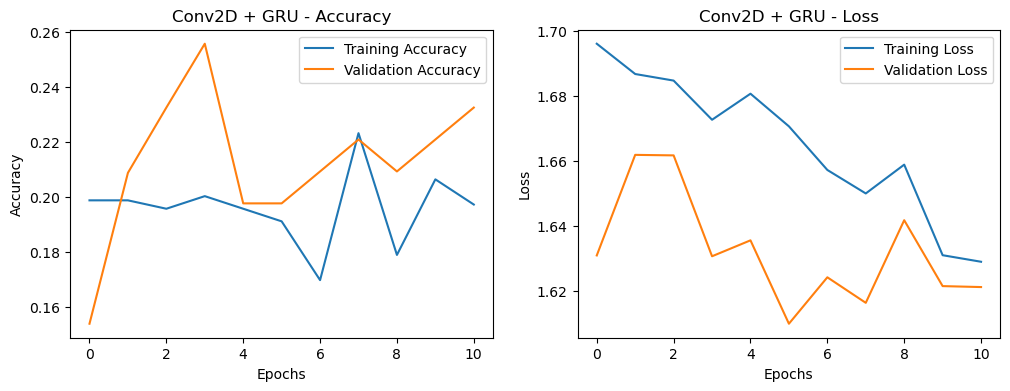

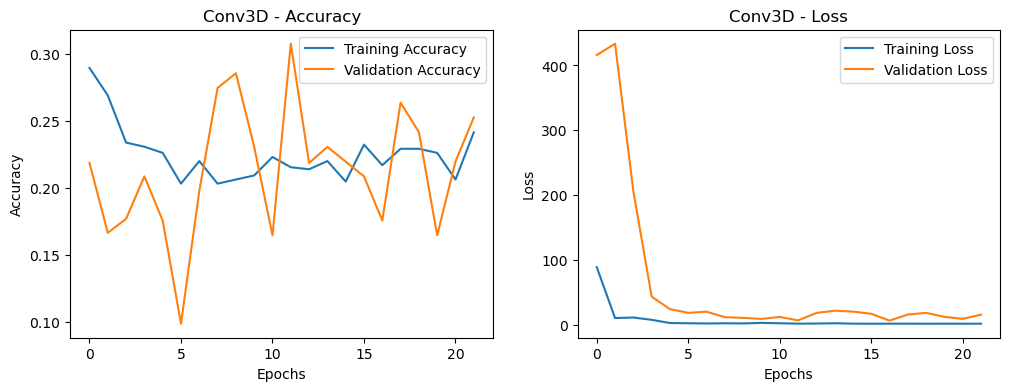

In [71]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy/loss
def plot_training_history(history, model_name):
    # Accuracy plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot metrics for Conv2D + GRU Model
plot_training_history(history_conv2d_gru, "Conv2D + GRU")

# Plot metrics for Conv3D Model
plot_training_history(history_conv3d, "Conv3D")


# EXPERIMENT NO.3

#### The goal of Experiment #3 was to build upon the findings from Experiment #2 to further enhance the performance of both Conv2D + GRU and Conv3D models. This experiment aimed to address residual issues and explore new strategies for optimization. Key objectives included:
* Fine-tuning model architecture: Adjusting Conv2D + GRU and Conv3D architectures to improve their learning capabilities and address overfitting more effectively.
* Refined data augmentation: Introducing more robust augmentation techniques, such as random rotations and contrast adjustments, to improve generalization.
* Optimized hyperparameters: Implementing learning rate warm-up and cyclical learning rates to enhance convergence during training.
* Class imbalance mitigation: Addressing class imbalance using oversampling and/or class weighting strategies during model training.
* Gradient clipping: Introducing gradient clipping to stabilize training and avoid exploding gradients in GRU-based models.

#### * Note: Steps 0 to 5 are not repeated. The experiment begins with Step 6 and incorporates the updated parameters and techniques.

# Step 6: Define Global Parameters

In [72]:
IMG_HEIGHT, IMG_WIDTH = 120, 120  # Start with lower resolution for progressive resizing
NUM_FRAMES = 30  # Number of frames in each video
BATCH_SIZE = 8  # Balanced batch size
NUM_CLASSES = 5  # Number of output gesture classes

# Step 7: Updated Data Preprocessing with Augmentation

In [73]:
def augment_frame(frame):
    if np.random.rand() > 0.5:
        frame = cv2.flip(frame, 1)  # Horizontal flip
    if np.random.rand() > 0.5:
        brightness_factor = np.random.uniform(0.8, 1.2)
        frame = cv2.convertScaleAbs(frame, alpha=brightness_factor, beta=0)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-10, 10)
        h, w = frame.shape[:2]
        M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1)
        frame = cv2.warpAffine(frame, M, (w, h))
    return frame

In [74]:
def load_video_frames_with_augmentation(video_path):
    frames = []
    frame_files = sorted([os.path.join(video_path, f) for f in os.listdir(video_path) if f.endswith(('.jpg', '.png'))])
    if len(frame_files) < NUM_FRAMES:
        raise ValueError(f"Insufficient frames in {video_path}. Found {len(frame_files)}, expected {NUM_FRAMES}.")
    for frame_file in frame_files[:NUM_FRAMES]:
        img = cv2.imread(frame_file)
        if img is not None:
            img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
            img = augment_frame(img)
            img = img / 255.0  # Normalize pixel values
            frames.append(img)
        else:
            raise ValueError(f"Error reading file: {frame_file}")
    return np.array(frames)

# Step 8: Data Generator

In [75]:
def data_generator_with_augmentation(csv_path, base_path, batch_size):
    data = np.genfromtxt(csv_path, delimiter=',', dtype=str, skip_header=1)
    while True:
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i + batch_size]
            X, Y = [], []
            for row in batch_data:
                folder_name, label = row[0], int(row[2])
                video_path = os.path.join(base_path, folder_name)
                frames = load_video_frames_with_augmentation(video_path)
                X.append(frames)
                Y.append(to_categorical(label, NUM_CLASSES))
            yield np.array(X), np.array(Y)

# Step 9: Simplified Conv2D + GRU Model

In [76]:
def build_conv2d_gru_model_experiment_3():
    video_input = Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(video_input)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = GRU(64, return_sequences=False)(x)  # Simplified to one GRU layer
    x = Dropout(0.3)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=video_input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 10: Updated Conv3D Model

In [77]:
def build_conv3d_model_experiment_3():
    model = Sequential([
        Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3)),
        Conv3D(32, (3, 3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),  # Reduced Dropout for stability
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 11: Instantiate Models

In [78]:
conv2d_gru_model = build_conv2d_gru_model_experiment_3()
conv3d_model = build_conv3d_model_experiment_3()

# Step 12: Setup Data Generators

In [79]:
train_generator = data_generator_with_augmentation(cleaned_train_csv_path, train_path, BATCH_SIZE)
val_generator = data_generator(cleaned_val_csv_path, val_path, BATCH_SIZE)

# Step 13: Define Training Parameters

In [80]:
steps_per_epoch = len(pd.read_csv(cleaned_train_csv_path)) // BATCH_SIZE
validation_steps = len(pd.read_csv(cleaned_val_csv_path)) // BATCH_SIZE

# Step 14: Configure Callbacks with Progressive Learning Rate

In [81]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(filepath='best_model_experiment_3.keras', monitor='val_loss', save_best_only=True)
]

# Step 15: Train the Models

In [82]:
# Conv2D + GRU Model
history_conv2d_gru = conv2d_gru_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.2912 - loss: 2.1519 - val_accuracy: 0.2083 - val_loss: 2.0625 - learning_rate: 0.0010
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3912 - loss: 1.6131 - val_accuracy: 0.2917 - val_loss: 1.7933 - learning_rate: 0.0010
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.4983 - loss: 1.3319 - val_accuracy: 0.3125 - val_loss: 1.6089 - learning_rate: 0.0010
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.4257 - loss: 1.3670 - val_accuracy: 0.3736 - val_loss: 1.4518 - learning_rate: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5268 - loss: 1.1521 - val_accuracy: 0.3956 - val_loss: 1.4277 - learning_rate: 0.0010
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5635 - loss: 1.0349 - val_accuracy: 0.2637 - val_loss: 1.7177 - learning_rate: 0.0010
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.5130 - loss: 1.1523 - 

In [83]:
# Conv3D Model
history_conv3d = conv3d_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 316s 4s/step - accuracy: 0.3109 - loss: 70.8695 - val_accuracy: 0.3333 - val_loss: 21.3531 - learning_rate: 0.0010
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 306s 4s/step - accuracy: 0.3261 - loss: 12.2347 - val_accuracy: 0.2292 - val_loss: 7.6730 - learning_rate: 0.0010
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.2251 - loss: 5.8342 - val_accuracy: 0.3854 - val_loss: 2.8758 - learning_rate: 0.0010
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.2583 - loss: 2.5518 - val_accuracy: 0.2198 - val_loss: 5.5072 - learning_rate: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.2244 - loss: 2.1647 - val_accuracy: 0.2088 - val_loss: 21.2390 - learning_rate: 0.0010
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.2027 - loss: 1.7791 - val_accuracy: 0.2637 - val_loss: 19.8501 - learning_rate: 0.0010
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 297s 4s/step - accuracy: 0.2396 - loss: 2.24

# Step 16: Save the Final Models

In [84]:
conv2d_gru_model.save('conv2d_gru_model_experiment_3.h5')
conv3d_model.save('conv3d_model_experiment_3.h5')

# Step 17: Evaluate the Models

In [85]:
gru_val_loss, gru_val_accuracy = conv2d_gru_model.evaluate(val_generator, steps=validation_steps)
print(f"Conv2D + GRU Model - Validation Loss: {gru_val_loss}, Validation Accuracy: {gru_val_accuracy}")

conv3d_val_loss, conv3d_val_accuracy = conv3d_model.evaluate(val_generator, steps=validation_steps)
print(f"Conv3D Model - Validation Loss: {conv3d_val_loss}, Validation Accuracy: {conv3d_val_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.7276 - loss: 0.7717
Conv2D + GRU Model - Validation Loss: 0.7921023368835449, Validation Accuracy: 0.7142857313156128
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.3157 - loss: 2.9888
Conv3D Model - Validation Loss: 4.135596752166748, Validation Accuracy: 0.3076923191547394


# Step 18: Plot Training History

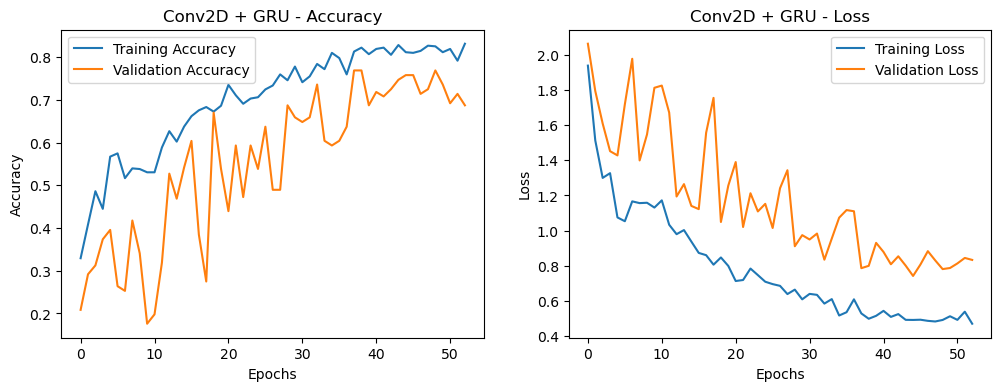

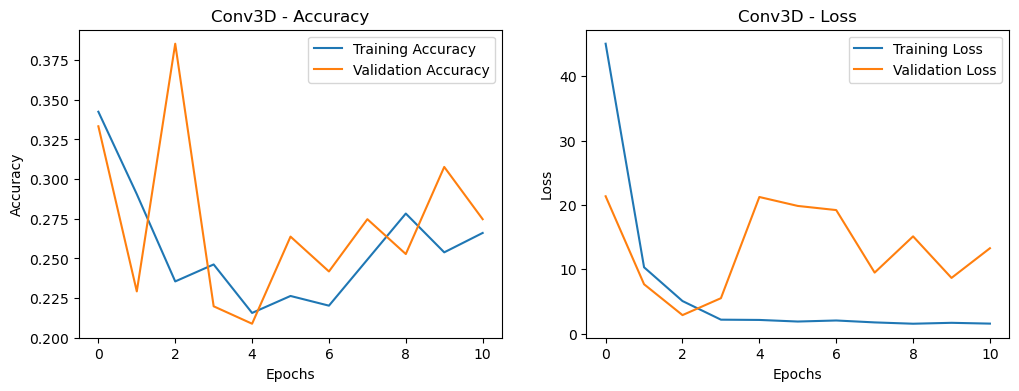

In [86]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history_conv2d_gru, "Conv2D + GRU")
plot_training_history(history_conv3d, "Conv3D")

# EXPERIMENT NO.4

# Step 6: Define Global Parameters

In [87]:
# Global Parameters
IMG_HEIGHT, IMG_WIDTH = 120, 120  # Start with uniform resolution
NUM_FRAMES = 30  # Number of frames per video
BATCH_SIZE = 8  # Balanced batch size for better training
NUM_CLASSES = 5  # Number of gesture classes
LEARNING_RATE = 0.001  # Initial learning rate

# Step 7: Data Preprocessing with Enhanced Augmentation

In [88]:
import cv2
import numpy as np

# Function to augment a single frame
def augment_frame(frame):
    if np.random.rand() > 0.5:
        frame = cv2.flip(frame, 1)  # Horizontal flip
    if np.random.rand() > 0.5:
        brightness_factor = np.random.uniform(0.8, 1.2)
        frame = cv2.convertScaleAbs(frame, alpha=brightness_factor, beta=0)
    if np.random.rand() > 0.5:
        scale_factor = np.random.uniform(0.9, 1.1)
        h, w = frame.shape[:2]
        resized_frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor)
        crop_x = max((resized_frame.shape[1] - w) // 2, 0)
        crop_y = max((resized_frame.shape[0] - h) // 2, 0)
        frame = resized_frame[crop_y:crop_y+h, crop_x:crop_x+w]
    return cv2.resize(frame, (IMG_HEIGHT, IMG_WIDTH))

In [89]:
# Function to preprocess video frames with augmentation
def load_video_frames_with_augmentation(video_path):
    frames = []
    frame_files = sorted([os.path.join(video_path, f) for f in os.listdir(video_path) if f.endswith(('.jpg', '.png'))])
    
    if len(frame_files) < NUM_FRAMES:
        raise ValueError(f"Insufficient frames in {video_path}. Found {len(frame_files)}, expected {NUM_FRAMES}.")
    
    for frame_file in frame_files[:NUM_FRAMES]:
        img = cv2.imread(frame_file)
        if img is not None:
            img = augment_frame(img)  # Apply augmentations
            img = img / 255.0  # Normalize pixel values
            frames.append(img)
        else:
            raise ValueError(f"Error reading file: {frame_file}")
    
    return np.array(frames)

# Step 8: Data Generator

In [90]:
from tensorflow.keras.utils import to_categorical

# Data generator with augmentation
def data_generator_with_augmentation(csv_path, base_path, batch_size, augment=False):
    data = np.genfromtxt(csv_path, delimiter=',', dtype=str, skip_header=1)
    while True:
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i + batch_size]
            X, Y = [], []
            for row in batch_data:
                folder_name, label = row[0], int(row[2])
                video_path = os.path.join(base_path, folder_name)
                if augment:
                    frames = load_video_frames_with_augmentation(video_path)
                else:
                    frames = load_video_frames(video_path)
                X.append(frames)
                Y.append(to_categorical(label, NUM_CLASSES))
            yield np.array(X), np.array(Y)

# Step 9: Build the Conv2D + GRU Model

In [91]:
from tensorflow.keras.layers import TimeDistributed, GRU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

def build_conv2d_gru_model_experiment_4():
    video_input = Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3))
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(video_input)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)
    x = BatchNormalization()(x)  # Added Batch Normalization
    x = GRU(64, return_sequences=False)(x)  # Single GRU layer
    x = Dropout(0.3)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=video_input, outputs=output)
    
    optimizer = Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)  # Gradient Clipping
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 10: Build the Conv3D Model

In [92]:
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

def build_conv3d_model_experiment_4():
    model = Sequential([
        Input(shape=(NUM_FRAMES, IMG_HEIGHT, IMG_WIDTH, 3)),
        Conv3D(32, (3, 3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),
        Conv3D(64, (3, 3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling3D((2, 2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.4),  # Slightly increased dropout
        Dense(NUM_CLASSES, activation='softmax')
    ])
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Step 11: Instantiate Models

In [93]:
conv2d_gru_model = build_conv2d_gru_model_experiment_4()
conv3d_model = build_conv3d_model_experiment_4()

# Step 12: Configure Callbacks

In [94]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(filepath='best_model_experiment_4.keras', monitor='val_loss', save_best_only=True)
]

# Step 13: Train Models

In [96]:
# Data generators
train_generator = data_generator_with_augmentation(cleaned_train_csv_path, train_path, BATCH_SIZE, augment=True)
val_generator = data_generator_with_augmentation(cleaned_val_csv_path, val_path, BATCH_SIZE, augment=False)

In [97]:
# Training Conv2D + GRU Model
history_conv2d_gru = conv2d_gru_model.fit(
    train_generator,
    steps_per_epoch=len(pd.read_csv(cleaned_train_csv_path)) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(pd.read_csv(cleaned_val_csv_path)) // BATCH_SIZE,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.3549 - loss: 2.0198 - val_accuracy: 0.2292 - val_loss: 1.8038 - learning_rate: 0.0010
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.3856 - loss: 1.6249 - val_accuracy: 0.3333 - val_loss: 1.7141 - learning_rate: 0.0010
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.3919 - loss: 1.6356 - val_accuracy: 0.3854 - val_loss: 1.4340 - learning_rate: 0.0010
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.4232 - loss: 1.4898 - val_accuracy: 0.4396 - val_loss: 1.2472 - learning_rate: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.4118 - loss: 1.5303 - val_accuracy: 0.3187 - val_loss: 1.6381 - learning_rate: 0.0010
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.4372 - loss: 1.5236 - val_accuracy: 0.3956 - val_loss: 1.4788 - learning_rate: 0.0010
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.4514 - loss: 1.3949 - 

In [98]:
# Training Conv3D Model
history_conv3d = conv3d_model.fit(
    train_generator,
    steps_per_epoch=len(pd.read_csv(cleaned_train_csv_path)) // BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=len(pd.read_csv(cleaned_val_csv_path)) // BATCH_SIZE,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 310s 4s/step - accuracy: 0.2397 - loss: 78.3379 - val_accuracy: 0.2967 - val_loss: 21.1461 - learning_rate: 0.0010
Epoch 2/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 301s 4s/step - accuracy: 0.2963 - loss: 11.9232 - val_accuracy: 0.2637 - val_loss: 105.0021 - learning_rate: 0.0010
Epoch 3/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 296s 4s/step - accuracy: 0.2587 - loss: 3.9412 - val_accuracy: 0.1648 - val_loss: 68.2412 - learning_rate: 0.0010
Epoch 4/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 2074s 26s/step - accuracy: 0.2776 - loss: 2.5965 - val_accuracy: 0.2088 - val_loss: 27.4941 - learning_rate: 0.0010
Epoch 5/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 285s 3s/step - accuracy: 0.2708 - loss: 1.8901 - val_accuracy: 0.1648 - val_loss: 16.5982 - learning_rate: 5.0000e-04
Epoch 6/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 292s 4s/step - accuracy: 0.3061 - loss: 2.1282 - val_accuracy: 0.3516 - val_loss: 11.8810 - learning_rate: 5.0000e-04
Epoch 7/100
82/82 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.243

# Step 14: Save Final Models

In [99]:
conv2d_gru_model.save('conv2d_gru_model_experiment_4.h5')
conv3d_model.save('conv3d_model_experiment_4.h5')

# Step 15: Evaluate the Models

In [100]:
from tensorflow.keras.models import load_model

# Reload Models (if needed)
conv2d_gru_model = load_model('conv2d_gru_model_experiment_4.h5')
conv3d_model = load_model('conv3d_model_experiment_4.h5')

# Evaluate Conv2D + GRU Model
gru_val_loss, gru_val_accuracy = conv2d_gru_model.evaluate(
    val_generator,
    steps=len(pd.read_csv(cleaned_val_csv_path)) // BATCH_SIZE
)
print(f"Conv2D + GRU Model - Validation Loss: {gru_val_loss}, Validation Accuracy: {gru_val_accuracy}")

# Evaluate Conv3D Model
conv3d_val_loss, conv3d_val_accuracy = conv3d_model.evaluate(
    val_generator,
    steps=len(pd.read_csv(cleaned_val_csv_path)) // BATCH_SIZE
)
print(f"Conv3D Model - Validation Loss: {conv3d_val_loss}, Validation Accuracy: {conv3d_val_accuracy}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step - accuracy: 0.5736 - loss: 1.1712
Conv2D + GRU Model - Validation Loss: 1.158200740814209, Validation Accuracy: 0.593406617641449
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 408ms/step - accuracy: 0.4221 - loss: 10.0861
Conv3D Model - Validation Loss: 9.23657512664795, Validation Accuracy: 0.4065934121608734


# Step 16: Plot Visuals

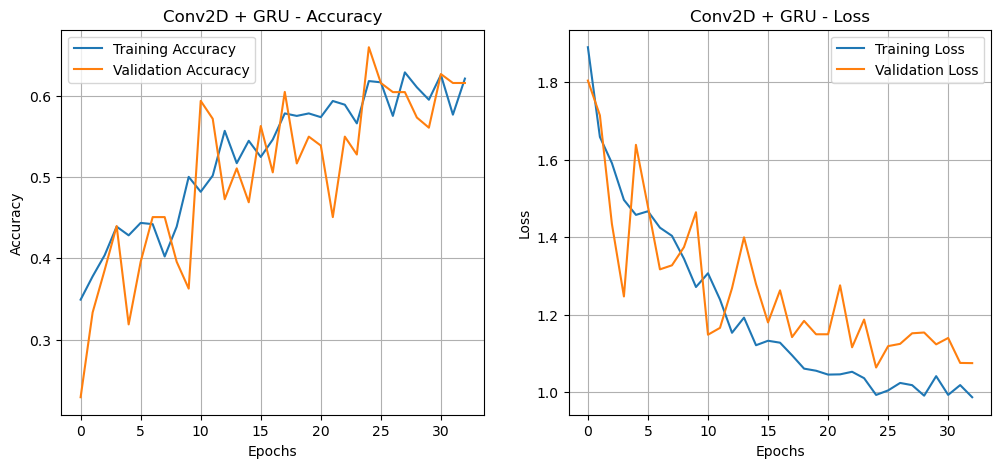

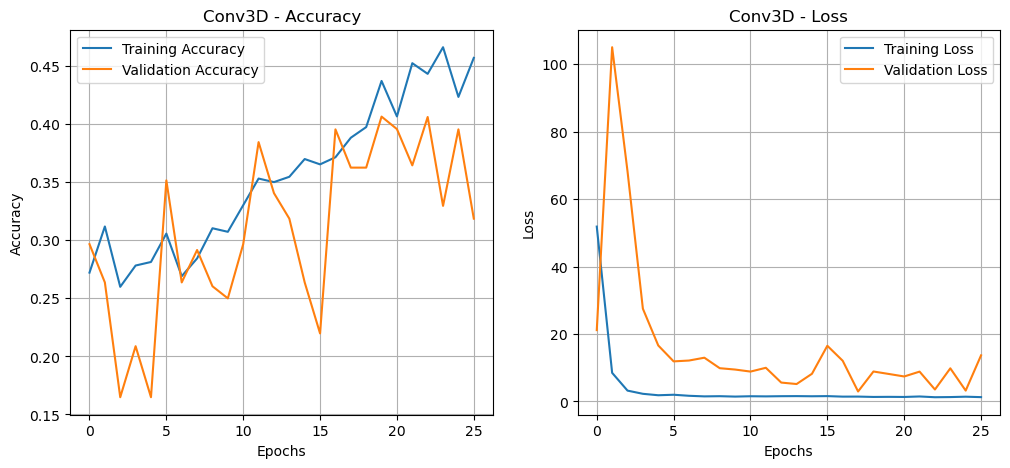

In [101]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_metrics(history, model_name):
    # Accuracy plot
    plt.figure(figsize=(12, 5))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

# Plot for Conv2D + GRU
plot_metrics(history_conv2d_gru, 'Conv2D + GRU')

# Plot for Conv3D
plot_metrics(history_conv3d, 'Conv3D')

# EXPERIMENT NO.5 : FINAL MODEL

## Step 6: Define Global Parameters

In [108]:
# Global Parameters
BATCH_SIZE = 16  # Number of samples per batch
IMAGE_SIZE = (120, 120)  # Fixed size for resizing/padding images
SEQ_LENGTH = 16  # Number of frames per gesture sequence
EPOCHS = 100  # Maximum number of training epochs
NUM_CLASSES = len(train_data_fixed['label'].unique())  # Dynamically calculated number of gesture classes

# Validate global parameters
print(f"Global Parameters:\n"
      f"BATCH_SIZE = {BATCH_SIZE}\n"
      f"IMAGE_SIZE = {IMAGE_SIZE}\n"
      f"SEQ_LENGTH = {SEQ_LENGTH}\n"
      f"EPOCHS = {EPOCHS}\n"
      f"NUM_CLASSES = {NUM_CLASSES}")

Global Parameters:
BATCH_SIZE = 16
IMAGE_SIZE = (120, 120)
SEQ_LENGTH = 16
EPOCHS = 100
NUM_CLASSES = 5


## Step 7: Handling Class Imbalance

In [110]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(train_data_fixed['label']), 
    y=train_data_fixed['label']
)
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}
print("Class weights computed:", class_weights_dict)

Class weights computed: {0: 0.9807407407407407, 1: 0.9664233576642336, 2: 1.0184615384615385, 3: 0.9664233576642336, 4: 1.0764227642276423}


## Step 8: Load and Pre-Process Data with Augmentation

In [111]:
import pandas as pd
import os

# Paths
base_path = "/Users/stillkraftphotography/Gesture Recognition Project/Project_data"
train_path = os.path.join(base_path, "train")
cleaned_train_csv_path = os.path.join(base_path, "cleaned_train.csv")

# Load CSV
train_data = pd.read_csv(cleaned_train_csv_path)

# Check for missing folders
missing_folders = []
for folder in train_data['folder_name']:
    folder_path = os.path.join(train_path, folder)
    if not os.path.exists(folder_path):
        missing_folders.append(folder)

if missing_folders:
    print("Missing folders:")
    for folder in missing_folders:
        print(folder)
else:
    print("All folders exist.")


All folders exist.


In [112]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical

# Define refined augmentation generator
def augment_and_save_images_in_subfolders(base_path, seq_length=16, image_size=(120, 120)):
    """
    Augment images for each class folder and save augmented images back to the same folder.

    Parameters:
    - base_path (str): Path to the base folder containing class subfolders.
    - seq_length (int): Length of sequences for Conv3D input.
    - image_size (tuple): Size to resize images.
    """
    # Define refined augmentation generator
    data_gen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,  # Increased shearing
    zoom_range=0.3,   # Increased zoom range
    brightness_range=[0.2, 1.0],  # Adjust brightness
    horizontal_flip=True,
    fill_mode='nearest'
)

    # Iterate through each class sub-folder
    for class_folder in os.listdir(base_path):
        class_path = os.path.join(base_path, class_folder)

        # Ensure it's a directory
        if not os.path.isdir(class_path):
            continue

        print(f"Processing class: {class_folder}")

        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)

            # Read and resize image
            img = cv2.imread(image_path)
            if img is None:
                continue  # Skip non-image files
            img = cv2.resize(img, image_size)

            # Apply augmentation
            augmented_img = data_gen.random_transform(img)
            augmented_img = np.clip(augmented_img, 0, 255).astype('uint8')  # Avoid pixel overflows
            augmented_file_name = f"{os.path.splitext(image_file)[0]}_augmented.jpg"
            augmented_file_path = os.path.join(class_path, augmented_file_name)
            cv2.imwrite(augmented_file_path, augmented_img)

# Helper function to load images
def load_images_from_folder(folder_path, image_size):
    """
    Load and resize images from a folder.
    """
    images = []
    for img_file in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images.append(img)
    return np.array(images)

# Load data and preprocess for training
def load_and_preprocess_data(base_path, data_csv_path, seq_length=16, image_size=(120, 120)):
    """
    Load images and prepare sequences for Conv3D.
    """
    data = pd.read_csv(data_csv_path)
    images, labels = [], []

    for _, row in data.iterrows():
        folder_path = os.path.join(base_path, row['folder_name'])
        label = row['label']

        # Load and process images
        folder_images = load_images_from_folder(folder_path, image_size)
        labels.extend([label] * len(folder_images))
        images.extend(folder_images)

    images = np.array(images)
    labels = np.array(labels)

    # Prepare sequences for Conv3D
    sequences, seq_labels = [], []
    for i in range(0, len(images) - seq_length + 1, seq_length):
        sequences.append(images[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])

    return np.array(images), labels, np.array(sequences), np.array(seq_labels)

# Augment images and save them
print("Starting image augmentation...")
augment_and_save_images_in_subfolders(train_path)
print("Image augmentation completed.")

# Load data with sequences for training
print("Loading and preprocessing train data...")
train_images, train_labels, train_sequences, train_seq_labels = load_and_preprocess_data(
    train_path, cleaned_train_csv_path, seq_length=SEQ_LENGTH, image_size=IMAGE_SIZE
)
print("Loading and preprocessing validation data...")
val_images, val_labels, val_sequences, val_seq_labels = load_and_preprocess_data(
    val_path, cleaned_val_csv_path, seq_length=SEQ_LENGTH, image_size=IMAGE_SIZE
)

# One-hot encode sequence labels
train_seq_labels_one_hot = to_categorical(train_seq_labels, NUM_CLASSES)
val_seq_labels_one_hot = to_categorical(val_seq_labels, NUM_CLASSES)

# Debugging outputs
print(f"Train images shape: {train_images.shape}, Train labels shape: {train_labels.shape}")
print(f"Train sequences shape: {train_sequences.shape}, Train sequence labels shape: {train_seq_labels.shape}")
print(f"Validation images shape: {val_images.shape}, Validation labels shape: {val_labels.shape}")
print(f"Validation sequences shape: {val_sequences.shape}, Validation sequence labels shape: {val_seq_labels.shape}")


Starting image augmentation...
Processing class: WIN_20180926_16_51_21_Pro_Thumbs_Down_new
Processing class: WIN_20180907_15_48_25_Pro_Thumbs Down_new
Processing class: WIN_20180926_17_19_06_Pro_Thumbs_Down_new
Processing class: WIN_20180926_16_55_16_Pro_Right_Swipe_new
Processing class: WIN_20180907_17_03_16_Pro_Right Swipe_new
Processing class: WIN_20180907_15_47_19_Pro_Thumbs Up_new
Processing class: WIN_20180926_16_55_47_Pro_Right_Swipe_new
Processing class: WIN_20180926_16_50_27_Pro_Thumbs_Up_new
Processing class: WIN_20180907_16_26_02_Pro_Thumbs Up_new
Processing class: WIN_20180907_16_16_27_Pro_Left Swipe_new_Left Swipe_new
Processing class: WIN_20180925_18_01_05_Pro_Right_Swipe_new
Processing class: WIN_20180926_17_49_29_Pro_Stop_new
Processing class: WIN_20180926_18_05_07_Pro_Right_Swipe_new
Processing class: WIN_20180925_17_22_32_Pro_Right_Swipe_new
Processing class: WIN_20180907_16_32_17_Pro_Left Swipe_new_Left Swipe_new
Processing class: WIN_20180907_16_05_58_Pro_Stop Gestu

## Step 9: Visualization of Augmented Data


Available class folders in /Users/stillkraftphotography/Gesture Recognition Project/Project_data/train:
['WIN_20180926_16_51_21_Pro_Thumbs_Down_new', 'WIN_20180907_15_48_25_Pro_Thumbs Down_new', 'WIN_20180926_17_19_06_Pro_Thumbs_Down_new', 'WIN_20180926_16_55_16_Pro_Right_Swipe_new', 'WIN_20180907_17_03_16_Pro_Right Swipe_new', 'WIN_20180907_15_47_19_Pro_Thumbs Up_new', 'WIN_20180926_16_55_47_Pro_Right_Swipe_new', 'WIN_20180926_16_50_27_Pro_Thumbs_Up_new', 'WIN_20180907_16_26_02_Pro_Thumbs Up_new', 'WIN_20180907_16_16_27_Pro_Left Swipe_new_Left Swipe_new', 'WIN_20180925_18_01_05_Pro_Right_Swipe_new', 'WIN_20180926_17_49_29_Pro_Stop_new', 'WIN_20180926_18_05_07_Pro_Right_Swipe_new', 'WIN_20180925_17_22_32_Pro_Right_Swipe_new', 'WIN_20180907_16_32_17_Pro_Left Swipe_new_Left Swipe_new', 'WIN_20180907_16_05_58_Pro_Stop Gesture_new', 'WIN_20180926_17_27_48_Pro_Thumbs_Up_new', 'WIN_20180926_17_41_15_Pro_Thumbs_Up_new', 'WIN_20180926_16_44_06_Pro_Left_Swipe_new', 'WIN_20180925_18_08_31_Pro_Th

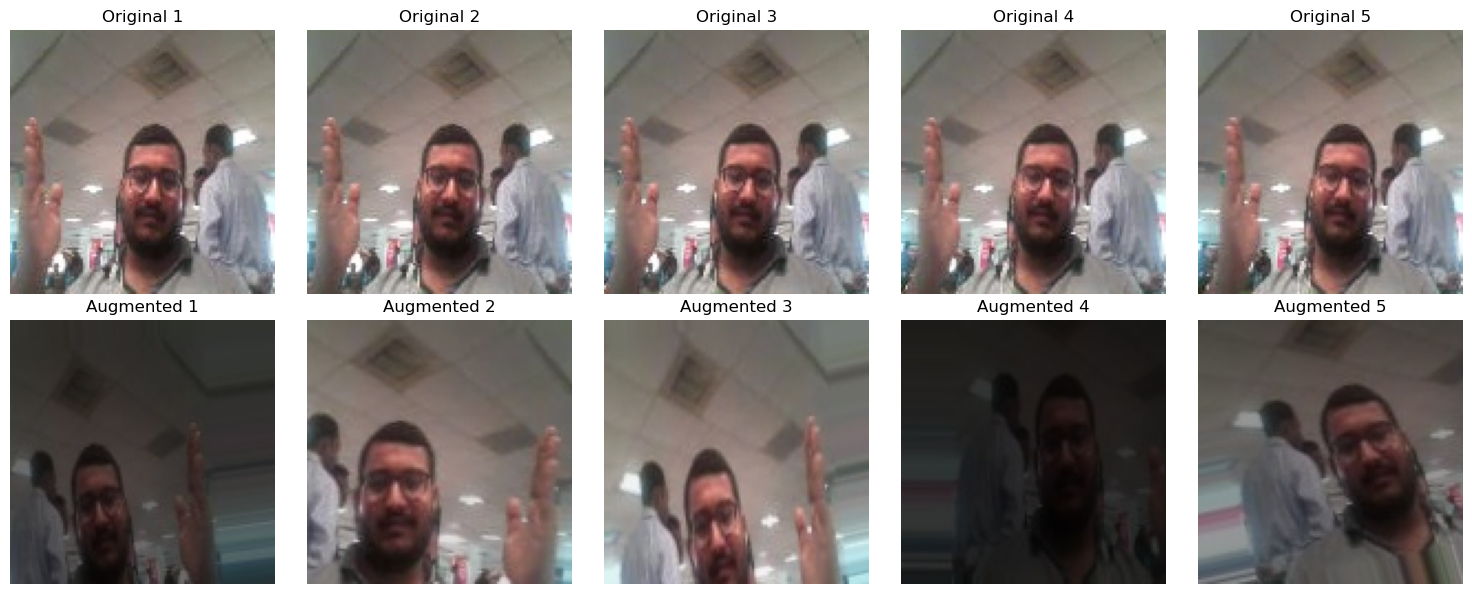

In [113]:
# Import necessary libraries
import os
import cv2
import matplotlib.pyplot as plt

# Function to visualize saved augmented images
def visualize_saved_augmented_images(base_path, keyword, image_size=(120, 120)):
    """
    Visualize original and augmented images in a specific class folder.

    Parameters:
    - base_path (str): Path to the base folder containing class subfolders.
    - keyword (str): Keyword to search for a class folder.
    - image_size (tuple): Size to resize images.
    """
    # Search for a folder containing the keyword
    matching_folders = [folder for folder in os.listdir(base_path) if keyword.lower() in folder.lower()]
    assert matching_folders, f"No folder found containing keyword: {keyword}"
    folder_to_visualize = os.path.join(base_path, matching_folders[0])
    print(f"Visualizing folder: {folder_to_visualize}")

    # Collect original and augmented images
    original_images, augmented_images = [], []
    for image_file in os.listdir(folder_to_visualize):
        image_path = os.path.join(folder_to_visualize, image_file)
        if "_augmented" in image_file:
            augmented_images.append(image_path)
        else:
            original_images.append(image_path)

    # Sort to align originals and augmentations
    original_images.sort()
    augmented_images.sort()

    # Ensure there are matching pairs
    num_images = min(len(original_images), len(augmented_images))
    assert num_images > 0, "No matching original and augmented images found for visualization."
    original_images = original_images[:num_images]
    augmented_images = augmented_images[:num_images]

    # Load and visualize
    fig, axes = plt.subplots(2, min(5, num_images), figsize=(15, 6))
    for i in range(min(5, num_images)):
        # Display original images
        img_original = cv2.imread(original_images[i])
        img_original = cv2.resize(img_original, image_size)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
        axes[0, i].imshow(img_original)
        axes[0, i].set_title(f"Original {i+1}")
        axes[0, i].axis('off')

        # Display augmented images
        img_augmented = cv2.imread(augmented_images[i])
        img_augmented = cv2.resize(img_augmented, image_size)
        img_augmented = cv2.cvtColor(img_augmented, cv2.COLOR_BGR2RGB)
        axes[1, i].imshow(img_augmented)
        axes[1, i].set_title(f"Augmented {i+1}")
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

# Example Usage
print(f"Available class folders in {train_path}:")
class_folders = os.listdir(train_path)
print(class_folders)

# Visualize a specific class folder
class_keyword = "Left_Swipe"  # Replace with a keyword
visualize_saved_augmented_images(train_path, class_keyword)


## Step 10: Build Conv2D + GRU Model

In [114]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, GRU, Dense, Dropout

def build_conv2d_gru_model_experiment_5():
    input_tensor = Input(shape=(30, 120, 120, 3), name="Input_Sequence")  # 30 frames per sequence

    # TimeDistributed 2D Convolutional layers
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu'))(input_tensor)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)

    # GRU layer to process temporal information
    x = GRU(128, return_sequences=False)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Output layer for classification
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    # Build the model
    model = Model(inputs=input_tensor, outputs=output)
    return model

conv2d_gru_model = build_conv2d_gru_model_experiment_5()
conv2d_gru_model.summary()


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Sequence (InputLayer)     │ (None, 30, 120, 120,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_27             │ (None, 30, 118, 118,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_28             │ (None, 30, 59, 59, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 30, 111392)     │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 128)            │    42,824,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,842,501 (163.43 MB)

 Trainable params: 42,842,501 (163.43 MB)

 Non-trainable params: 0 (0.00 B)

## Step 11: Build Conv3D Model


In [115]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout

def build_conv3d_model_experiment_5():
    input_tensor = Input(shape=(30, 120, 120, 3), name="Conv3D_Input")  # 30 frames per sequence
    x = Conv3D(32, (3, 3, 3), activation='relu')(input_tensor)
    x = MaxPooling3D((2, 2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)
    return Model(inputs=input_tensor, outputs=output)

conv3d_model = build_conv3d_model_experiment_5()
conv3d_model.summary()


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv3D_Input (InputLayer)       │ (None, 30, 120, 120,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_19 (Conv3D)              │ (None, 28, 118, 118,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_18 (MaxPooling3D) │ (None, 14, 59, 59, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 1559488)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │   199,614,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 199,617,861 (761.48 MB)

 Trainable params: 199,617,861 (761.48 MB)

 Non-trainable params: 0 (0.00 B)

## Step 12: Fusion Model

In [117]:
from tensorflow.keras.layers import (Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
                                     Conv3D, MaxPooling3D, Concatenate)

def build_fusion_model_experiment_5(conv2d_model, conv3d_model):
    conv2d_input, conv3d_input = conv2d_gru_model.input, conv3d_model.input
    conv2d_output, conv3d_output = conv2d_model.output, conv3d_model.output

    merged = Concatenate()([conv2d_output, conv3d_output])
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.3)(x)
    output = Dense(NUM_CLASSES, activation='softmax')(x)

    return Model(inputs=[conv2d_input, conv3d_input], outputs=output)

fusion_model = build_fusion_model_experiment_5(conv2d_gru_model, conv3d_model)
fusion_model.summary()

Model: "functional_48"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Sequence      │ (None, 30, 120,   │          0 │ -                 │
│ (InputLayer)        │ 120, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_27 │ (None, 30, 118,   │        896 │ Input_Sequence[0… │
│ (TimeDistributed)   │ 118, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv3D_Input        │ (None, 30, 120,   │          0 │ -                 │
│ (InputLayer)        │ 120, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_28 │ (None, 30, 59,    │          0 │ time_distributed… │
│ (TimeDistributed)   │ 59, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_19 (Conv3D)  │ (None, 28, 118,   │      2,624 │ Conv3D_Input[0][… │
│                     │ 118, 32)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_29 │ (None, 30,        │          0 │ time_distributed… │
│ (TimeDistributed)   │ 111392)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_18    │ (None, 14, 59,    │          0 │ conv3d_19[0][0]   │
│ (MaxPooling3D)      │ 59, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ (None, 128)       │ 42,824,448 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_19          │ (None, 1559488)   │          0 │ max_pooling3d_18… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │     16,512 │ gru_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 128)       │ 199,614,5… │ flatten_19[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ dense_27[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 128)       │          0 │ dense_29[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 5)         │        645 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 5)         │        645 │ dropout_16[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 10)        │          0 │ dense_28[0][0],   │
│ (Concatenate)       │                   │            │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128)       │      1,408 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 128)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 5)         │        645 │ dropout_17[0][0]

 Total params: 242,462,415 (924.92 MB)

 Trainable params: 242,462,415 (924.92 MB)

 Non-trainable params: 0 (0.00 B)

## Step 13: Instantiate Models

In [118]:
conv2d_gru_model = build_conv2d_gru_model_experiment_5()
conv3d_model = build_conv3d_model_experiment_5()
fusion_model = build_fusion_model_experiment_5(conv2d_gru_model, conv3d_model)

## Step 14: Compile Models

In [119]:
conv2d_gru_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Use categorical crossentropy
    metrics=['accuracy']
)


conv3d_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

fusion_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

## Step 15: Configure Callbacks


In [120]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)
]

## Step 16: Train Models

In [121]:
# Debugging the shapes
print(f"Train Sequences Shape: {train_sequences.shape}")  # Should be (num_samples, ...)
print(f"Train Labels Shape: {train_labels.shape}")        # Should match the number of samples in train_sequences

# Ensure that train_sequences and train_labels have the same number of samples
if len(train_sequences) != len(train_labels):
    print(f"Mismatch detected: {len(train_sequences)} sequences vs {len(train_labels)} labels.")

    # If train_labels is larger, truncate to match train_sequences
    if len(train_labels) > len(train_sequences):
        train_labels = train_labels[:len(train_sequences)]
        print(f"Train labels truncated to match sequences. New shape: {train_labels.shape}")

    # If train_sequences is larger, truncate to match train_labels
    elif len(train_sequences) > len(train_labels):
        train_sequences = train_sequences[:len(train_labels)]
        print(f"Train sequences truncated to match labels. New shape: {train_sequences.shape}")

# If using class_weight or sample_weight, ensure no mismatch in size
if "class_weights_dict" in locals():
    print(f"Class Weights Dict: {class_weights_dict}")
    # Validate weights if needed (typically based on label distribution)

# Sanity check final shapes
print(f"Final Train Sequences Shape: {train_sequences.shape}")
print(f"Final Train Labels Shape: {train_labels.shape}")

Train Sequences Shape: (2482, 16, 120, 120, 3)
Train Labels Shape: (39720,)
Mismatch detected: 2482 sequences vs 39720 labels.
Train labels truncated to match sequences. New shape: (2482,)
Class Weights Dict: {0: 0.9807407407407407, 1: 0.9664233576642336, 2: 1.0184615384615385, 3: 0.9664233576642336, 4: 1.0764227642276423}
Final Train Sequences Shape: (2482, 16, 120, 120, 3)
Final Train Labels Shape: (2482,)


In [122]:

print(f"Train Sequences Shape: {train_sequences.shape}")  # Should be (2482, 16, 120, 120, 3)
print(f"Train Labels Shape: {train_labels.shape}")      # Should be (2482,)
print(f"Validation Sequences Shape: {val_sequences.shape}")  # Should be (185, 16, 120, 120, 3)
print(f"Validation Labels Shape: {val_labels.shape}")        # Should be (185,)


Train Sequences Shape: (2482, 16, 120, 120, 3)
Train Labels Shape: (2482,)
Validation Sequences Shape: (185, 16, 120, 120, 3)
Validation Labels Shape: (2970,)


In [123]:
# Check and fix val_labels shape
print(f"Validation Labels Shape Before Fix: {val_labels.shape}")
val_labels = val_labels[:val_sequences.shape[0]]  # Match the number of sequences
print(f"Validation Labels Shape After Fix: {val_labels.shape}")


Validation Labels Shape Before Fix: (2970,)
Validation Labels Shape After Fix: (185,)


In [124]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_sequences = pad_sequences(train_sequences, maxlen=30, padding='post', dtype='float32')
val_sequences = pad_sequences(val_sequences, maxlen=30, padding='post', dtype='float32')

In [125]:
# Use integer labels, not one-hot encoded labels
history = conv2d_gru_model.fit(
    train_sequences, 
    train_seq_labels_one_hot,  # One-hot encoded labels
    validation_data=(val_sequences, val_seq_labels_one_hot),  # One-hot encoded labels
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=callbacks  # Ensure you're passing the callbacks list directly
)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1295s 8s/step - accuracy: 0.1850 - loss: 1.6113 - val_accuracy: 0.2324 - val_loss: 1.6055 - learning_rate: 0.0010
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1234s 8s/step - accuracy: 0.2171 - loss: 1.6107 - val_accuracy: 0.2108 - val_loss: 1.6089 - learning_rate: 0.0010
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1190s 8s/step - accuracy: 0.2093 - loss: 1.6100 - val_accuracy: 0.1676 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1213s 8s/step - accuracy: 0.1889 - loss: 1.6092 - val_accuracy: 0.1676 - val_loss: 1.6092 - learning_rate: 0.0010
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1233s 8s/step - accuracy: 0.1958 - loss: 1.6095 - val_accuracy: 0.2108 - val_loss: 1.6090 - learning_rate: 5.0000e-04
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1222s 8s/step - accuracy: 0.1918 - loss: 1.6090 - val_accuracy: 0.2108 - val_loss: 1.6085 - learning_rate: 5.0000e-04
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1203s 8s/step - accur

In [126]:
# Train the Conv3D model with one-hot encoded labels
history = conv3d_model.fit(
    train_sequences, 
    train_seq_labels_one_hot,  # One-hot encoded labels
    validation_data=(val_sequences, val_seq_labels_one_hot),  # One-hot encoded labels
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weights_dict,
    callbacks=callbacks  # Ensure you're passing the callbacks list directly
)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 711s 5s/step - accuracy: 0.1880 - loss: 3900.8335 - val_accuracy: 0.1676 - val_loss: 1.6022 - learning_rate: 0.0010
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.1988 - loss: 1.6207 - val_accuracy: 0.1730 - val_loss: 1.6026 - learning_rate: 0.0010
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 701s 4s/step - accuracy: 0.1968 - loss: 1.6100 - val_accuracy: 0.1622 - val_loss: 1.6204 - learning_rate: 0.0010
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.1958 - loss: 1.5955 - val_accuracy: 0.1676 - val_loss: 1.6035 - learning_rate: 0.0010
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 701s 4s/step - accuracy: 0.2212 - loss: 1.5931 - val_accuracy: 0.1676 - val_loss: 1.6040 - learning_rate: 5.0000e-04
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.2089 - loss: 1.5803 - val_accuracy: 0.1676 - val_loss: 1.6037 - learning_rate: 5.0000e-04
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 701s 4s/step - accuracy:

In [127]:
# Train Fusion Model
fusion_model.fit(
    [train_sequences, train_sequences],  # Both inputs should be train_sequences for fusion model
    train_seq_labels_one_hot,  # Labels
    validation_data=([val_sequences, val_sequences], val_seq_labels_one_hot),  # Both validation sequences 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

Epoch 1/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1598s 10s/step - accuracy: 0.1970 - loss: 1.6152 - val_accuracy: 0.2270 - val_loss: 1.6081 - learning_rate: 0.0010
Epoch 2/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1600s 10s/step - accuracy: 0.2137 - loss: 1.6114 - val_accuracy: 0.1622 - val_loss: 1.6123 - learning_rate: 0.0010
Epoch 3/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1595s 10s/step - accuracy: 0.1936 - loss: 1.6124 - val_accuracy: 0.2270 - val_loss: 1.6062 - learning_rate: 0.0010
Epoch 4/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 9901s 64s/step - accuracy: 0.1898 - loss: 1.6148 - val_accuracy: 0.1676 - val_loss: 1.6111 - learning_rate: 0.0010
Epoch 5/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1544s 10s/step - accuracy: 0.1913 - loss: 1.6135 - val_accuracy: 0.1622 - val_loss: 1.6122 - learning_rate: 0.0010
Epoch 6/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1515s 10s/step - accuracy: 0.1916 - loss: 1.6141 - val_accuracy: 0.1676 - val_loss: 1.6101 - learning_rate: 0.0010
Epoch 7/100
156/156 ━━━━━━━━━━━━━━━━━━━━ 1542s 10s/step - accura

## Step 17: Save Final Models

In [128]:
conv2d_gru_model_experiment_5.save('conv2d_gru_model_experiment_5.h5')
conv3d_model_experiment_5.save('conv3d_model_experiment_5.h5')
fusion_model_experiment_5.save('fusion_model_experiment_5.h5')